In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Loading the dataset

In [2]:
img = np.load('/global/cfs/projectdirs/cosmo/work/users/usf_cs690_2022_fall/data/images.npy')
img.shape

(20000, 125, 125, 3)

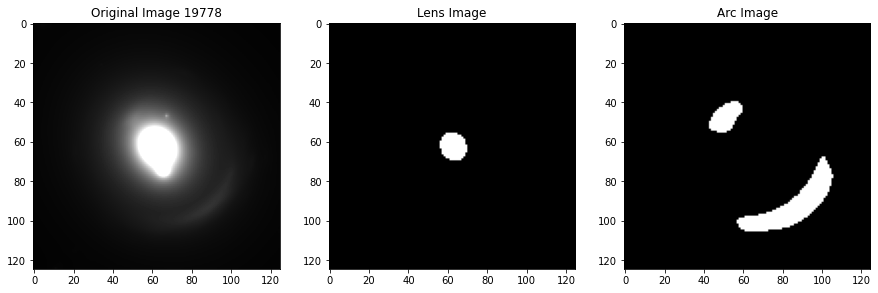

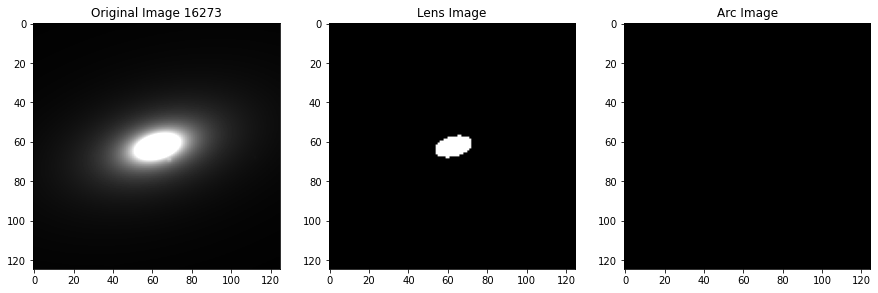

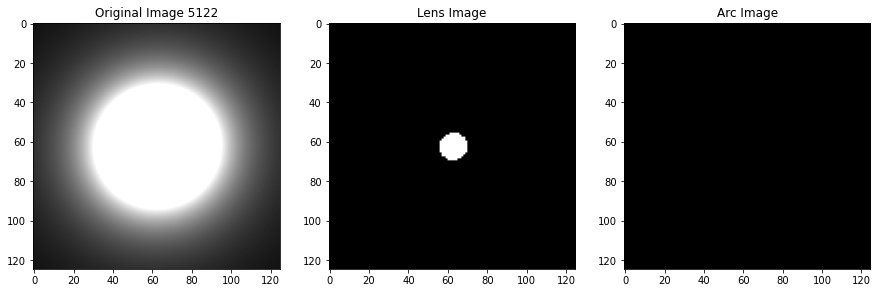

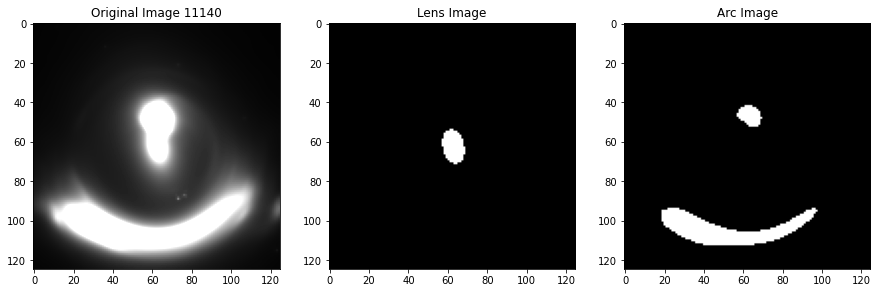

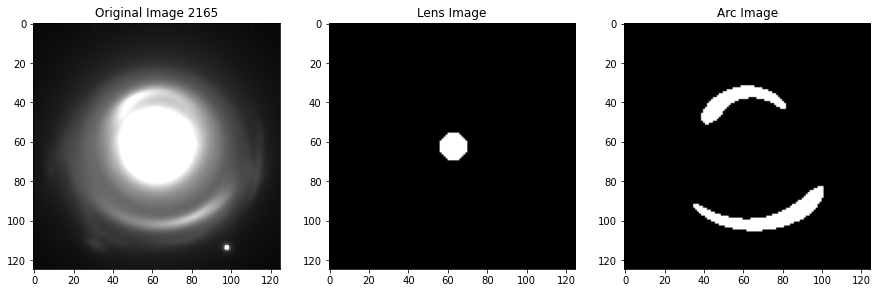

In [107]:
for im in np.random.choice(list(range(img.shape[0])), 5):
    # Scaling such that arc and the lens are of same brightness(say of lens)
    num, den = np.sum(img_raw[im,:,:,1]), np.sum(img_raw[im,:,:,2])
    factor = num/den if den!=0 else 1

    fig, ax = plt.subplots(1,3,figsize=(15, 15))
    ax[0].set_title(f'Original Image {im}')
    ax[0].imshow(img[im,:,:,0], vmin = 0, vmax = np.percentile(img_raw[im,:,:,0], 99), cmap="gray")
    ax[1].set_title('Lens Image')
    ax[1].imshow(img[im,:,:,1], cmap="gray")
    ax[2].set_title('Arc Image')
    ax[2].imshow(img[im,:,:,2], cmap="gray")
    plt.show()

## 2. Raw dataset

In [2]:
img_raw = np.load('/global/cfs/projectdirs/deepsrch/jwst_sims/pristine_bright_masks2/images.npy')
img_raw.shape

(20000, 125, 125, 3)

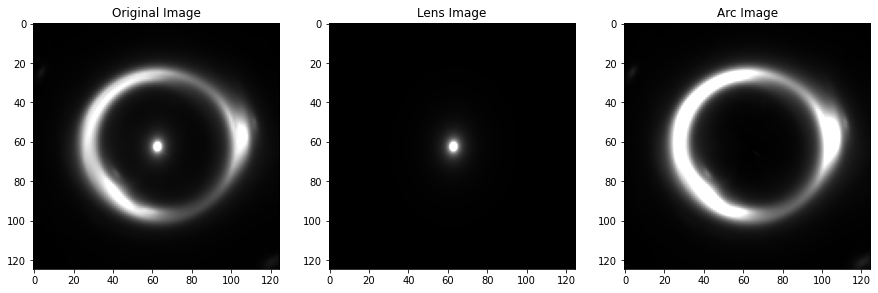

In [3]:
# Visualising the image
# First channel is the image, second is the lens and 3rd is the arc
im = 1000
fig, ax = plt.subplots(1,3,figsize=(15, 15))
ax[0].set_title('Original Image')
ax[0].imshow(img_raw[im,:,:,0], vmin = 0, vmax = np.percentile(img_raw[im,:,:,0], 99), cmap="gray")
ax[1].set_title('Lens Image')
ax[1].imshow(img_raw[im,:,:,1], vmin = 0, vmax = np.percentile(img_raw[im,:,:,0], 99), cmap = "gray")
ax[2].set_title('Arc Image')
ax[2].imshow(img_raw[im,:,:,2], vmin = 0, vmax = np.percentile(img_raw[im,:,:,0], 95), cmap="gray")
plt.show()

In [4]:
print(f'Max Min values : {img_raw[im,:,:,0].max()}, {img_raw[im,:,:,0].min()},\
      {img_raw[im,:,:,1].max()}, {img_raw[im,:,:,1].min()},\
      {img_raw[im,:,:,2].max()}, {img_raw[im,:,:,2].min()}')

Max Min values : 7215.288295522982, 1.9524181125627285,      7203.753027887626, 0.6104943407841773,      2541.621672634241, 1.3232978261419197


### 2.1 Generating the Mask

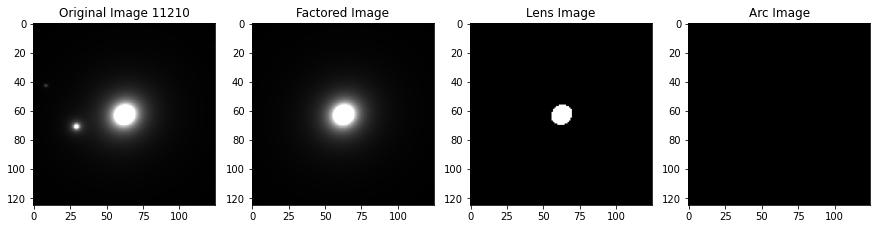

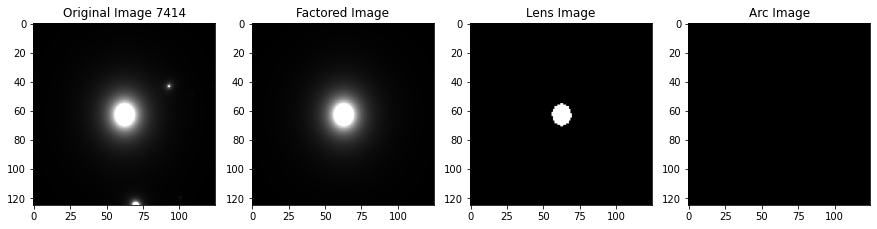

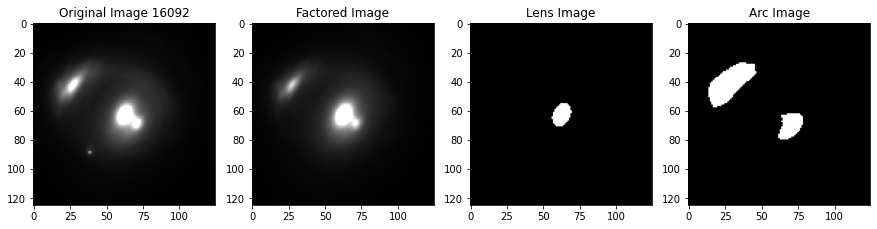

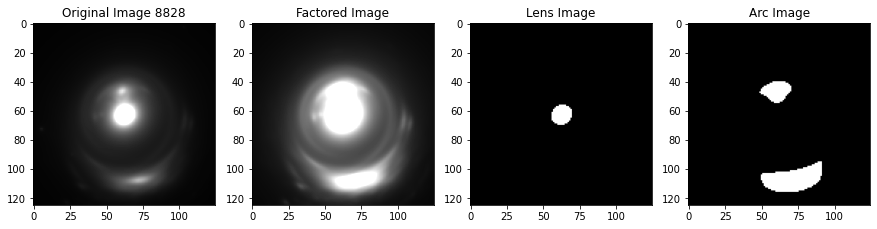

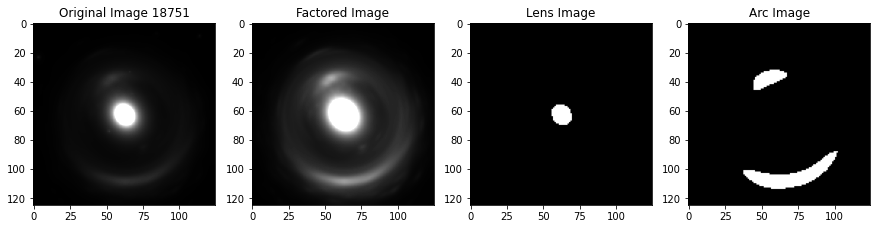

In [6]:
# Image '0' has a very faint arc and is not possible to visualise the arc, thus refactoring of somekind is necessary to see the arc.

for im in np.random.choice(list(range(img_raw.shape[0])), 5):
    # Scaling such that arc and the lens are of same brightness(say of lens)
    num, den = np.mean(img_raw[im,:,:,1]), np.mean(img_raw[im,:,:,2])
    factor = num/den if den!=0 else 1

    lens_mask = img_raw[im,:,:,1] >= np.percentile(img_raw[im,:,:,1], 99)
    arc_mask = img_raw[im,:,:,2] >= np.percentile(img_raw[im,:,:,2], 95)
    fig, ax = plt.subplots(1,4,figsize=(15, 15))
    ax[0].set_title(f'Original Image {im}')
    ax[0].imshow(img_raw[im,:,:,0], vmin = 0, vmax = np.percentile(img_raw[im,:,:,0], 99), cmap="gray")
    ax[1].set_title('Factored Image')
    ax[1].imshow(img_raw[im,:,:,1]*2 + img_raw[im,:,:,2]*factor, vmin = 0, vmax = np.percentile(img_raw[im,:,:,0]*2/factor, 99), cmap = "gray")
    ax[2].set_title('Lens Image')
    ax[2].imshow(lens_mask, cmap="gray")
    ax[3].set_title('Arc Image')
    ax[3].imshow(arc_mask, cmap="gray")
    plt.show()

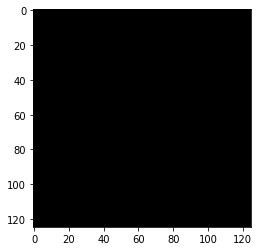

In [10]:
plt.imshow(img_raw[7414,:,:,2],cmap="gray")
plt.show()

In [12]:
np.sum(img_raw[7414:,:,2]), np.sum(img_raw[11210:,:,2])

(185773709.58750418, 131450308.18583302)

In [104]:
# Let's just stick with selecting 99th percentile for lens and 95th percentile for arc
def generate_mask():
    non_lens, non_arc = 0, 0
    for im in (range(img_raw.shape[0])):
        if np.sum(img_raw[im,:,:,1]) == 0:
            non_lens += 1
        if np.sum(img_raw[im,:,:,2]) == 0:
            non_arc += 1
        img_new[im,:,:,1] = img_raw[im,:,:,1] >= np.percentile(img_raw[im,:,:,1], 99)
        img_new[im,:,:,2] = img_raw[im,:,:,2] >= np.percentile(img_raw[im,:,:,2], 95)
    
    print(f'Total non-lens images : {non_lens}, Total non-arc images : {non_arc}')

In [105]:
img_new = img_raw.copy()
generate_mask()

Total non-lens images : 0, Total non-arc images : 10000


### 2.3 Visualising the Mask

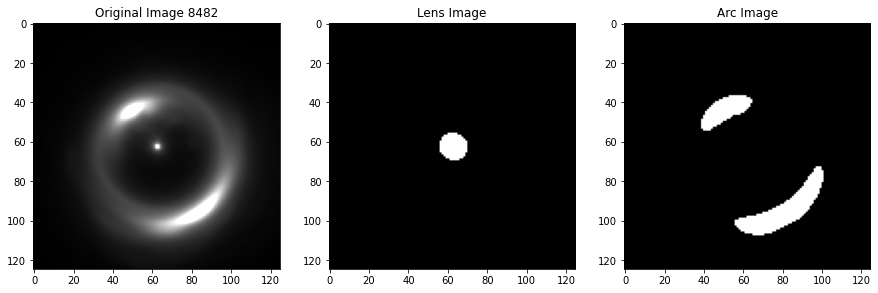

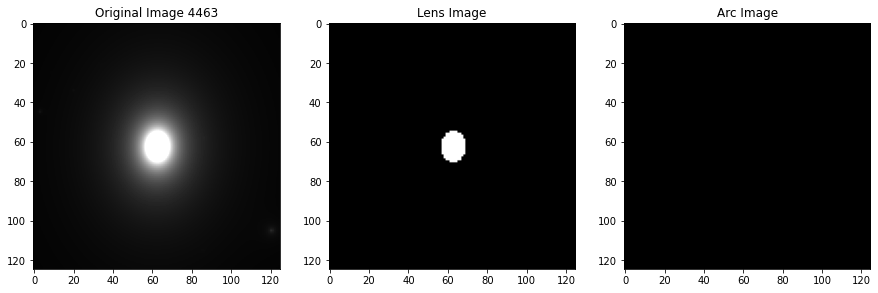

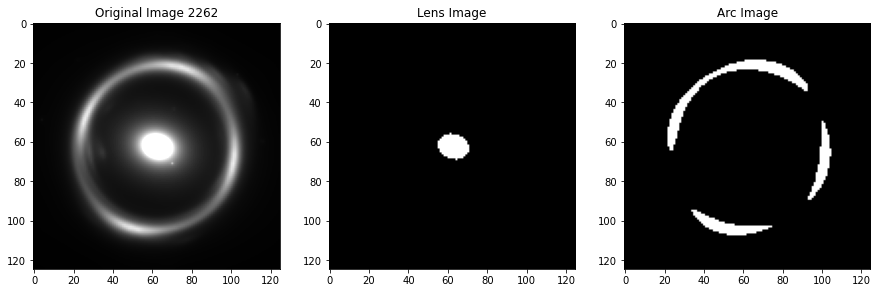

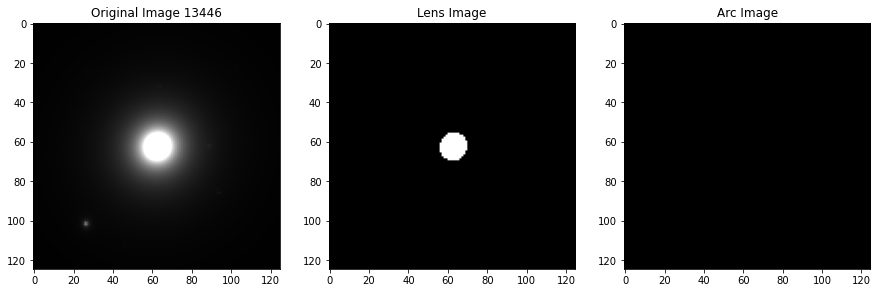

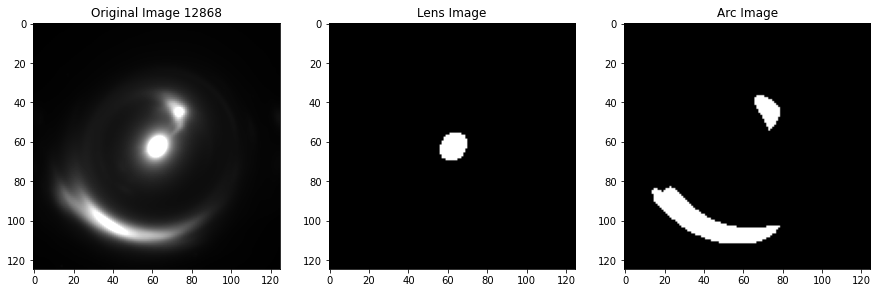

In [106]:
for im in np.random.choice(list(range(img_new.shape[0])), 5):
    fig, ax = plt.subplots(1,3,figsize=(15, 15))
    ax[0].set_title(f'Original Image {im}')
    ax[0].imshow(img_new[im,:,:,0], vmin = 0, vmax = np.percentile(img_new[im,:,:,0], 99), cmap="gray")
    ax[1].set_title('Lens Image')
    ax[1].imshow(img_new[im,:,:,1], cmap="gray")
    ax[2].set_title('Arc Image')
    ax[2].imshow(img_new[im,:,:,2], cmap="gray")
    plt.show()

### 2.4 Saving images

In [21]:
np.save("../data/images_shri.npy", img_new)

## 3. Data Analysis

In [14]:
# Loading the saved data
img_new = np.load('../data/images_shri.npy')
img_new.shape

(20000, 125, 125, 3)

In [22]:
# Check the max value along the axis in the image
def sep_lenses(img_arr):
    lens_idx, nonlens_idx = [], []
    for i in range(img_arr.shape[0]):
        # for non-lenses all the pixels would have a value of 1.0, thus a total of 125 x 125
        if np.sum(img_arr[i,:,:,2]) != 15625:
            lens_idx.append(i)
        else:
            nonlens_idx.append(i)
    print(len(lens_idx), len(nonlens_idx))

    img_lenses = img_arr[lens_idx]
    img_nlenses = img_arr[nonlens_idx]
    
    return img_lenses, img_nlenses

In [23]:
img_lenses, img_nlenses = sep_lenses(img_new)

10000 10000


(array([1.54883e+05, 8.44000e+02, 2.33000e+02, 1.08000e+02, 4.80000e+01,
        3.00000e+01, 2.80000e+01, 1.40000e+01, 1.20000e+01, 0.00000e+00,
        1.00000e+01, 4.00000e+00, 1.00000e+01, 2.00000e+00, 4.00000e+00,
        2.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 6.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 2.00000e+00]),
 array([2.50255737e-01, 5.19106901e+02, 1.03796355e+03, 1.55682019e+03,
        2.07567684e+03, 2.59453348e+03, 3.11339013e+03, 3.63224677e+03,
        4.15110342e+03, 4.66996006e+03, 5.18881671e+03, 5.70767335e+03,
        6.22653000e+03, 6.74538664e+03, 7.26424329e+

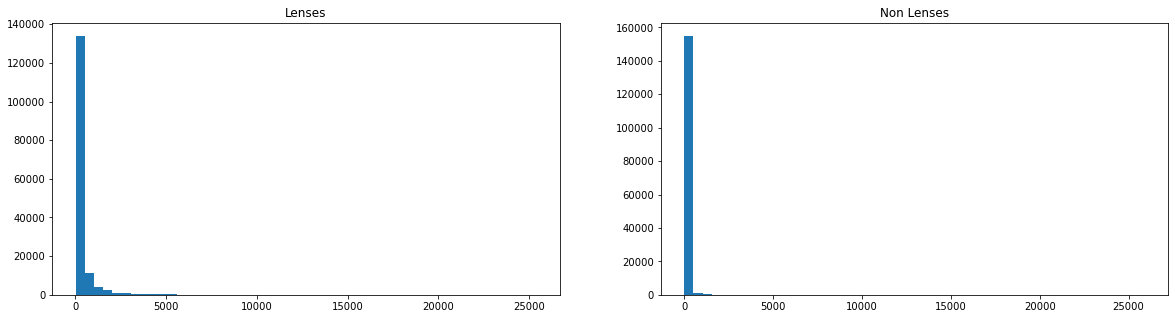

In [178]:
# Visualising
Nbins = 50
fig, ax = plt.subplots(1,2,figsize=(20,5))

# Lenses
ax[0].set_title('Lenses')
idx = np.random.choice(range(10000),10)
flat = img_lenses[idx,:,:,0].flat
ax[0].hist(flat, Nbins)
#ax[0].set_xlim([0, img_lenses[1,:,:,0].max()])

# non-Lenses
ax[1].set_title('Non Lenses')
idx = np.random.choice(range(10000),10)
flat = img_nlenses[idx,:,:,0].flat
ax[1].hist(flat, Nbins)
#ax[0,1].set_xlim([0, img_nlenses[1,:,:,0].max()])

In [18]:
# Normalising the data
def normalize(img_arr):
    nimg_lens = img_arr.copy()
    for i in range(img_lenses.shape[0]):
        image = nimg_lens[i,:,:,0] 
        image = image/np.percentile(image, 99)
        #image = image*4
        nimg_lens[i,:,:,0] = ((image - image.min())*255)/image.max() 
        
        lens_mask = nimg_lens[i,:,:,1]
        lens_mask = lens_mask/np.percentile(lens_mask, 99)
        nimg_lens[i,:,:,1] = ((lens_mask - lens_mask.min())*255)/lens_mask.max() 
        
        arc_mask = nimg_lens[i,:,:,2]
        arc_mask = arc_mask/np.percentile(arc_mask, 99)
        nimg_lens[i,:,:,2] = ((arc_mask - arc_mask.min())*255)/arc_mask.max()
        
    
    return nimg_lens


In [19]:
# normalized img lenses, normalized img non lenses 
nimg_lens = normalize(img_lenses)
nimg_nlens = normalize(img_nlenses)

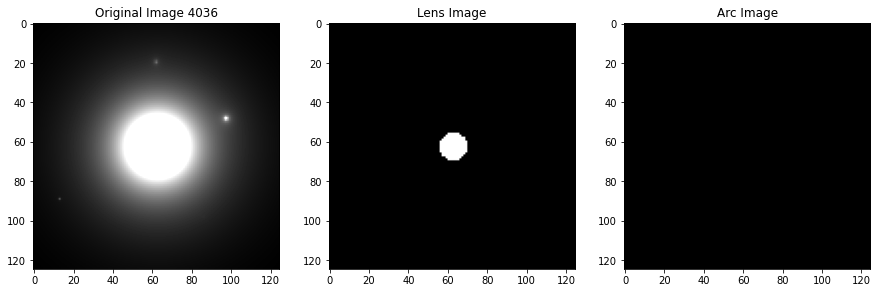

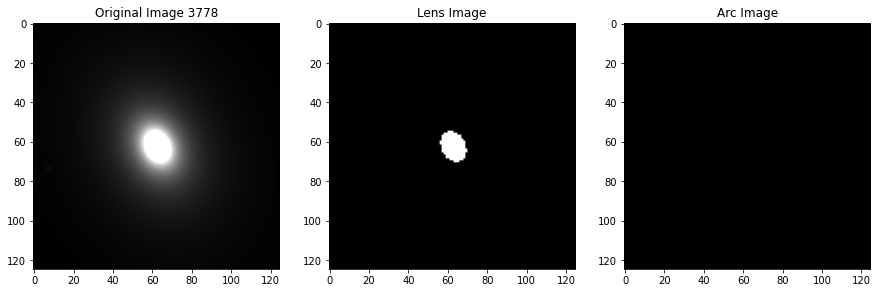

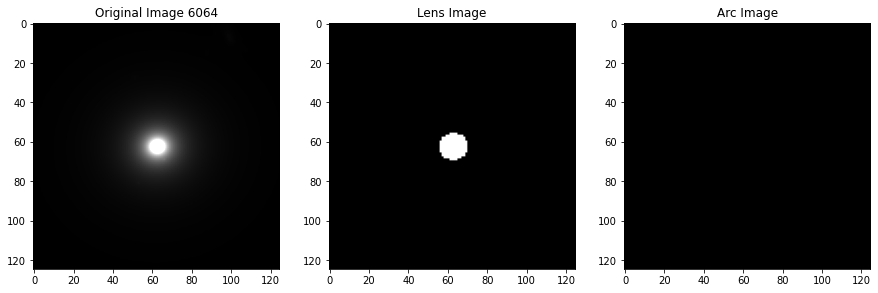

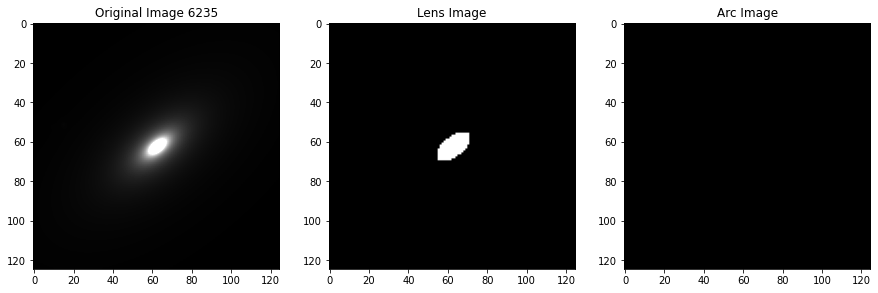

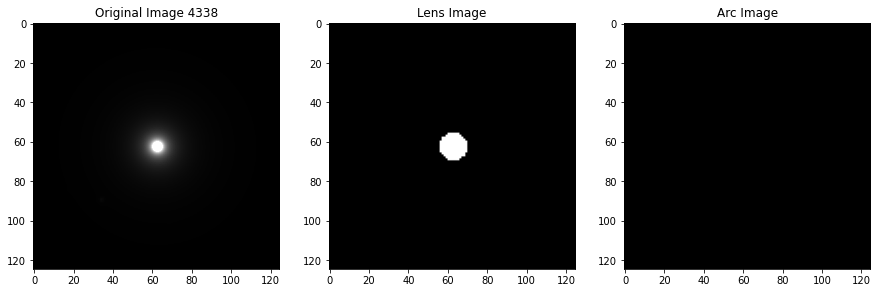

In [27]:
for im in np.random.choice(list(range(nimg_nlens.shape[0])), 5):
    # Scaling such that arc and the lens are of same brightness(say of lens)
    fig, ax = plt.subplots(1,3,figsize=(15, 15))
    ax[0].set_title(f'Original Image {im}')
    ax[0].imshow(nimg_nlens[im,:,:,0], vmin = 0, vmax = np.percentile(nimg_lens[im,:,:,0], 99), cmap="gray")
    ax[1].set_title('Lens Image')
    ax[1].imshow(nimg_nlens[im,:,:,1], cmap="gray")
    ax[2].set_title('Arc Image')
    ax[2].imshow(nimg_nlens[im,:,:,2], cmap="gray")
    plt.show()

## 4. Transform size

In [7]:
def transform_img(img_arr):
    result = np.zeros((img_arr.shape[0],128,128,3))
    y_mid, x_mid = (128-125) // 2, (128-125) // 2
    for i in range(img_arr.shape[0]):
        image = img_arr[i,:,:,:]
        image[:,:,0] = np.clip(image[:,:,0], 0,  np.percentile(image[:,:,0], 99))
        image[:,:,1] = np.clip(image[:,:,1], 0,  np.percentile(image[:,:,1], 99))
        image[:,:,2] = np.clip(image[:,:,2], 0,  np.percentile(image[:,:,2], 95))
        result[i,x_mid:x_mid+125,y_mid:y_mid+125,:] = image
        
    return result

In [8]:
# transform img lenses, transform img non lenses
timg_lens = transform_img(nimg_lens)
timg_nlens = transform_img(nimg_nlens)

timg_lens.shape, timg_nlens.shape

((10000, 128, 128, 3), (10000, 128, 128, 3))

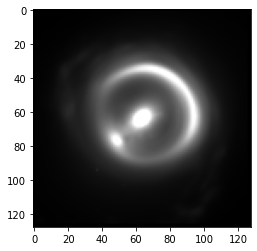

In [9]:
plt.imshow(timg_lens[7877,:,:,0], cmap="gray")
plt.show()

## 5. Split the data into train, val and test

In [10]:
# 80% train, 10% val and 10% test
def train_val_test_split(lens, nlens, split=0.8):
    n_samples = lens.shape[0]
    shuffled_idx = np.random.permutation(n_samples)
    
    # Getting the index
    train_idx, val_idx, test_idx = shuffled_idx[:int(split*n_samples)],\
                                    shuffled_idx[int(split*n_samples):int((split+0.1)*n_samples)],\
                                    shuffled_idx[int((split+0.1)*n_samples):]
    
    # Generating train, val and test sets
    x_train = np.vstack([lens[train_idx,:,:,0], nlens[train_idx,:,:,0]])
    y_train_lens = np.vstack([lens[train_idx,:,:,1], nlens[train_idx,:,:,1]])
    y_train_arcs = np.vstack([lens[train_idx,:,:,2], nlens[train_idx,:,:,2]])
    # x_train, y_train_lens, y_train_arcs = np.expand_dims(x_train, axis=-1),\
    #                                       np.expand_dims(y_train_lens, axis=-1),\
    #                                       np.expand_dims(y_train_arcs, axis=-1)  
    
    x_val = np.vstack([lens[val_idx,:,:,0], nlens[val_idx,:,:,0]])
    y_val_lens = np.vstack([lens[val_idx,:,:,1], nlens[val_idx,:,:,1]])
    y_val_arcs = np.vstack([lens[val_idx,:,:,2], nlens[val_idx,:,:,2]])
    # x_val, y_val_lens, y_val_arcs = np.expand_dims(x_val, axis=-1),\
    #                                       np.expand_dims(y_val_lens, axis=-1),\
    #                                       np.expand_dims(y_val_arcs, axis=-1) 
    
    x_test = np.vstack([lens[test_idx,:,:,0], nlens[test_idx,:,:,0]])
    y_test_lens = np.vstack([lens[test_idx,:,:,1], nlens[test_idx,:,:,1]])
    y_test_arcs = np.vstack([lens[test_idx,:,:,2], nlens[test_idx,:,:,2]])
    # x_test, y_test_lens, y_test_arcs = np.expand_dims(x_test, axis=-1),\
    #                                       np.expand_dims(y_test_lens, axis=-1),\
    #                                       np.expand_dims(y_test_arcs, axis=-1) 
    
    # Reshuffling the data to mix lenses and non lenses
    idx = np.random.permutation(x_train.shape[0])
    x_train, y_train_lens, y_train_arcs = x_train[idx], y_train_lens[idx], y_train_arcs[idx]
    
    idx = np.random.permutation(x_val.shape[0])
    x_val, y_val_lens, y_val_arcs = x_val[idx], y_val_lens[idx], y_val_arcs[idx]
    x_test, y_test_lens, y_test_arcs = x_test[idx], y_test_lens[idx], y_test_arcs[idx]
    
    return (x_train, y_train_lens, y_train_arcs,\
            x_val, y_val_lens, y_val_arcs, \
            x_test, y_test_lens, y_test_arcs)
    

In [11]:
x_train, y_train_lens, y_train_arcs,\
x_val, y_val_lens, y_val_arcs, \
x_test, y_test_lens, y_test_arcs = train_val_test_split(timg_lens, timg_nlens)

In [12]:
x_train.shape, x_test.shape, x_val.shape

((16000, 128, 128), (2000, 128, 128), (2000, 128, 128))

In [13]:
# Plotting the data
def plot_imgs(img_arr, lens, arcs):
    for im in np.random.choice(list(range(img_arr.shape[0])), 5):
        fig, ax = plt.subplots(1,3,figsize=(15, 15))
        ax[0].set_title(f'Original Image {im}')
        ax[0].imshow(img_arr[im,:,:], cmap="gray")
        ax[1].set_title('Lens Image')
        ax[1].imshow(lens[im,:,:], cmap="gray")
        ax[2].set_title('Arc Image')
        ax[2].imshow(arcs[im,:,:], cmap="gray")
        plt.show()

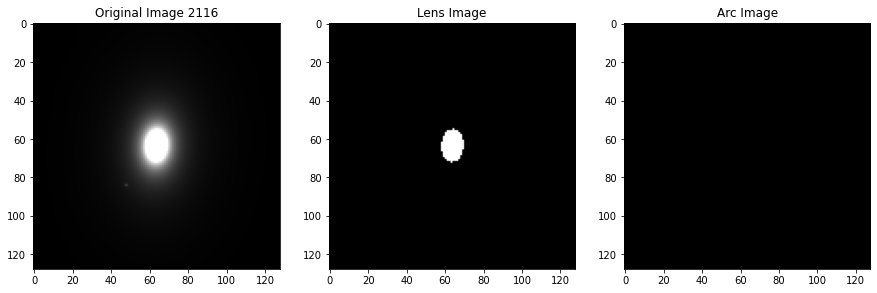

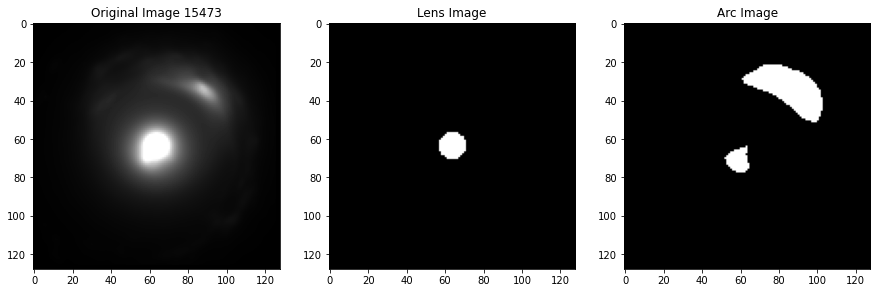

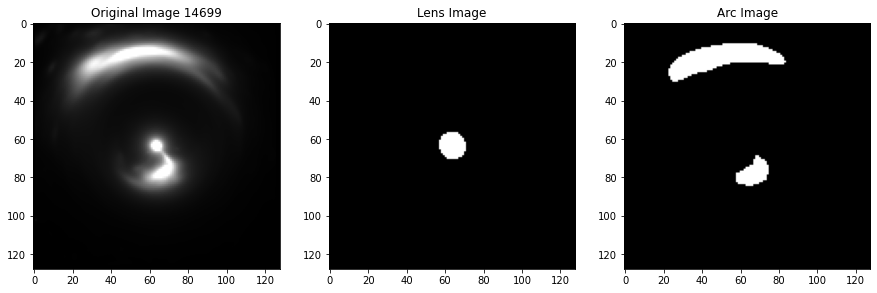

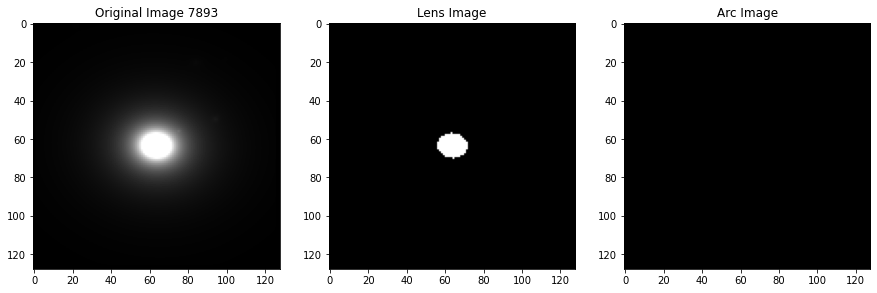

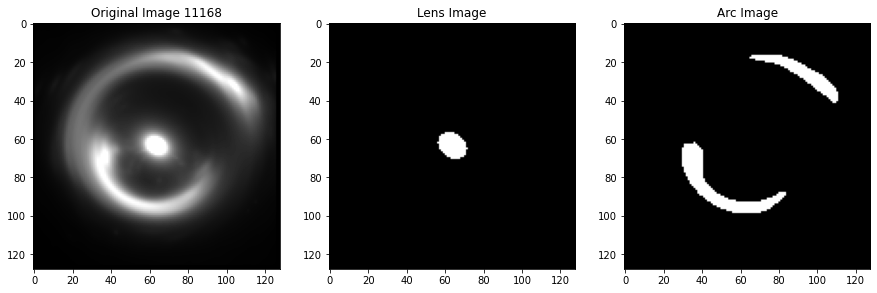

In [16]:
# Train-set
plot_imgs(x_train, y_train_lens, y_train_arcs)

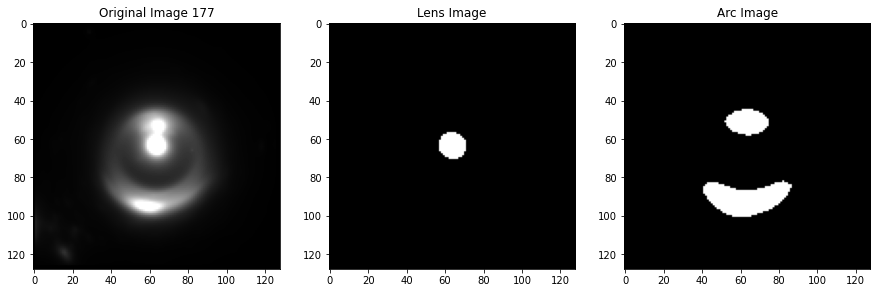

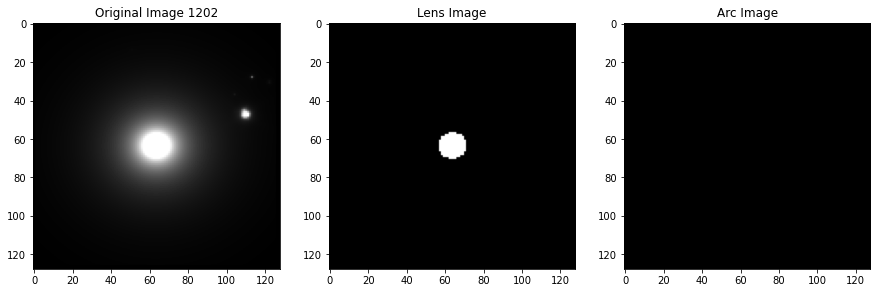

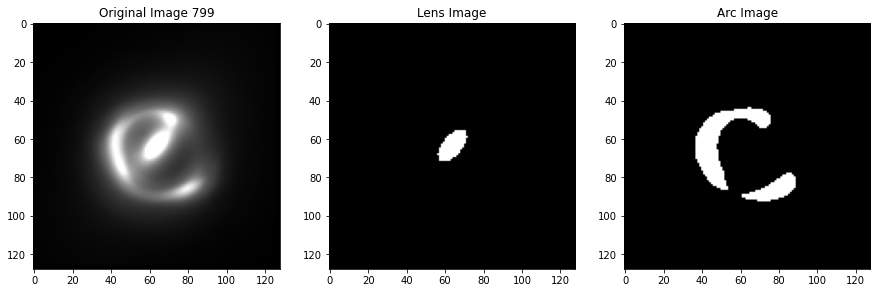

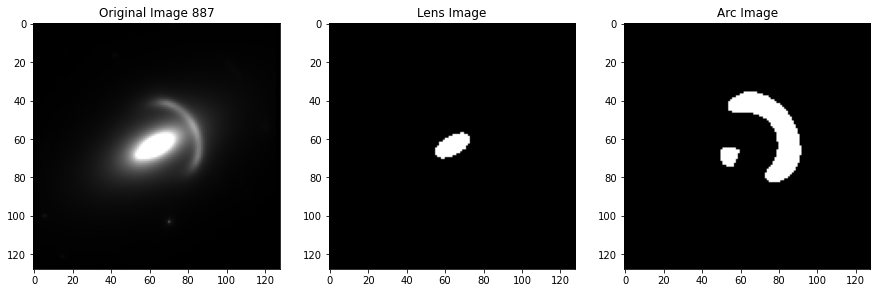

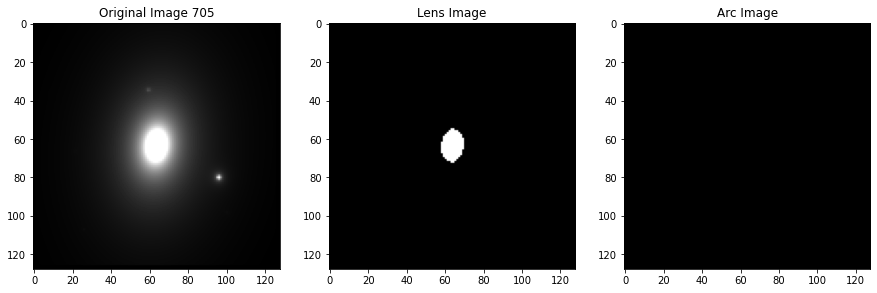

In [17]:
# Val-set
plot_imgs(x_val, y_val_lens, y_val_arcs)

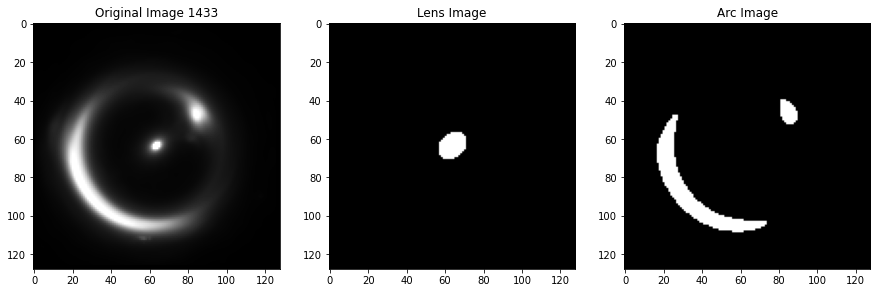

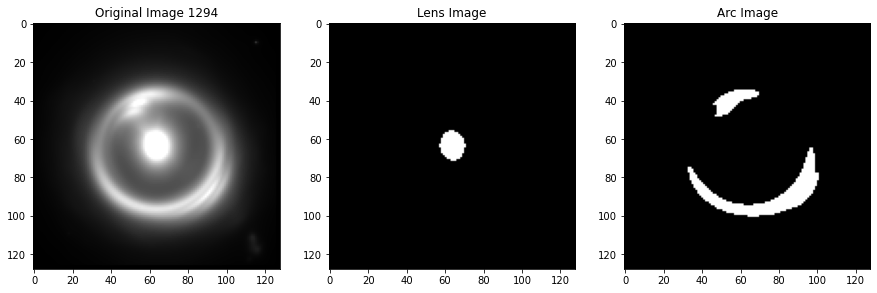

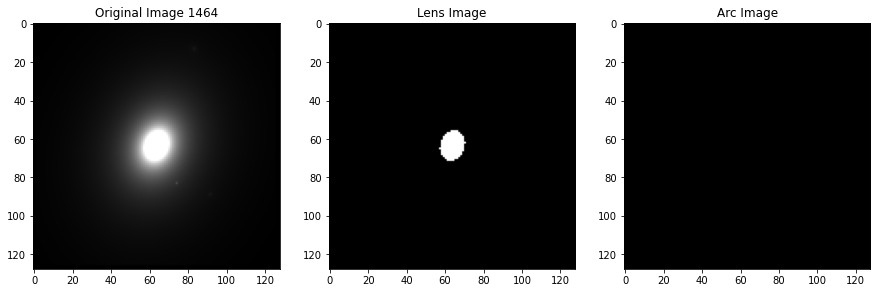

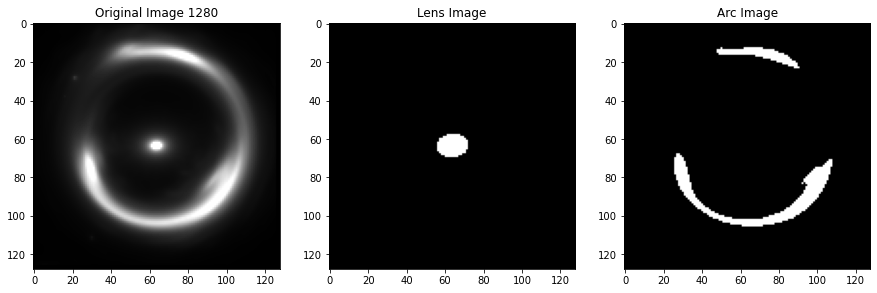

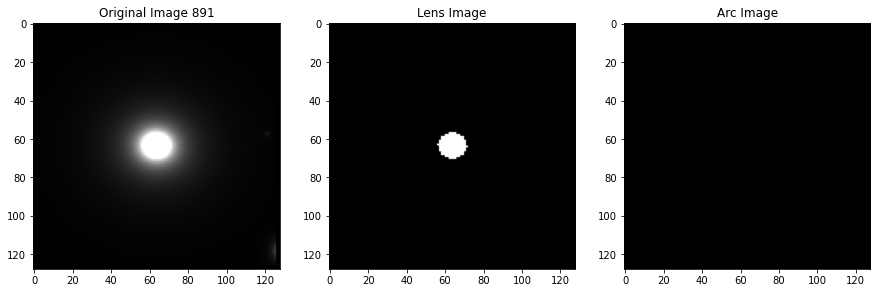

In [18]:
# test-set
plot_imgs(x_test, y_test_lens, y_test_arcs)

## 6. Saving the data

In [19]:
# data/simul/train/images, data/simul/train/lens_mask, data/simul/train/arc_mask
np.save("../data/simul/train/images/imgs_128.npy", x_train)
np.save("../data/simul/train/lens_mask/lens_masks_128.npy", y_train_lens)
np.save("../data/simul/train/arc_mask/arc_masks_128.npy", y_train_arcs)

# Validation
np.save("../data/simul/val/images/imgs_128.npy", x_val)
np.save("../data/simul/val/lens_mask/lens_masks_128.npy", y_val_lens)
np.save("../data/simul/val/arc_mask/arc_masks_128.npy", y_val_arcs)

# Test
np.save("../data/simul/test/images/imgs_128.npy", x_test)
np.save("../data/simul/test/lens_mask/lens_masks_128.npy", y_test_lens)
np.save("../data/simul/test/arc_mask/arc_masks_128.npy", y_test_arcs)

In [20]:
x_train, y_train_arcs = np.load("../data/simul/train/images/imgs_128.npy"),\
                        np.load("../data/simul/train/arc_mask/arc_masks_128.npy")
x_train.shape

(16000, 128, 128)

In [21]:
def get_image_v2(image_arr, mask=False):
    '''All images are of size 256 x 256'''
    # Get the edge
    edge = cv2.Canny(np.uint8(image_arr), 10, 1000)
    
    # Rescale image
    img_arr = image_arr/255.0
    if mask:
        img_arr = (img_arr >= 0.5).astype(int)
    
    # adding 1 dimension at the end
    img_arr = np.expand_dims(img_arr, axis=-1)
    
    return img_arr, edge

In [24]:
img_arr, edge = get_image_v2(y_train_arcs[952])

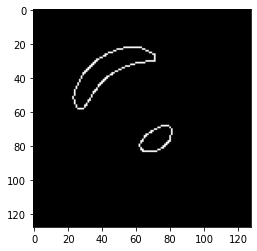

In [25]:
#im = np.asarray(im).astype(np.float32)/255.0
plt.imshow(edge, cmap="gray")
plt.show()